In [11]:
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [14]:
import numpy as np
import pandas as pd
import os

# Listing all files under the dataset path
dataset_path = r"C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3"

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-balanced-mapping.txt
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-balanced-test.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-balanced-train.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-byclass-mapping.txt
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-byclass-test.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-byclass-train.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-bymerge-mapping.txt
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-bymerge-test.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-bymerge-train.csv
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-digits-mapping.txt
C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versio

In [19]:
# Load the dataset files
testing_letter = pd.read_csv(r'C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-letters-test.csv')
training_letter = pd.read_csv(r'C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-letters-train.csv')

# Print the shapes of the datasets
print("Training dataset shape:", training_letter.shape)
print("Testing dataset shape:", testing_letter.shape)

Training dataset shape: (88799, 785)
Testing dataset shape: (14799, 785)


In [20]:
y1 = np.array(training_letter.iloc[:,0].values)
x1 = np.array(training_letter.iloc[:,1:].values)
#testing_labels
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(88799,)
(88799, 784)


In [28]:
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)
     

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Load and preprocess the dataset
def load_and_preprocess_data(training_letter, testing_letter):
    y1 = np.array(training_letter.iloc[:, 0].values)
    x1 = np.array(training_letter.iloc[:, 1:].values, dtype=np.float32)
    y2 = np.array(testing_letter.iloc[:, 0].values)
    x2 = np.array(testing_letter.iloc[:, 1:].values, dtype=np.float32)

    # Normalize pixel values
    x1 = x1 / 255.0
    x2 = x2 / 255.0

    # Reshape to (num_samples, 28, 28, 1)
    x1 = x1.reshape(-1, 28, 28, 1)
    x2 = x2.reshape(-1, 28, 28, 1)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y1 = encoder.fit_transform(y1.reshape(-1, 1)).astype(np.float32)
    y2 = encoder.transform(y2.reshape(-1, 1)).astype(np.float32)

    print("Number of classes:", y1.shape[1])  # Debugging line
    return x1, y1, x2, y2


# Define the CNN model
def create_cnn_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),

        layers.GlobalAveragePooling2D(),  # Global average pooling
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    return model


# Main function
def main(training_letter, testing_letter, batch_size=64, epochs=20):
    # Load and preprocess data
    x_train, y_train, x_test, y_test = load_and_preprocess_data(training_letter, testing_letter)

    # Convert to TensorFlow tensors
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    # Initialize model, loss function, and optimizer
    num_classes = y_train.shape[1]
    model = create_cnn_model(num_classes=num_classes)

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0003),
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Add early stopping and learning rate scheduler
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return model


if __name__ == "__main__":
    # Ensure datasets are loaded
    assert 'training_letter' in globals(), "Training dataset not loaded!"
    assert 'testing_letter' in globals(), "Testing dataset not loaded!"

    # Train the model
    model = main(training_letter, testing_letter)

Number of classes: 26
Epoch 1/20


C:\Users\admin\.anaconda\New folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1388/1388 ━━━━━━━━━━━━━━━━━━━━ 293s 209ms/step - accuracy: 0.4785 - loss: 1.6911 - val_accuracy: 0.8646 - val_loss: 0.4213 - learning_rate: 3.0000e-04
Epoch 2/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 295s 212ms/step - accuracy: 0.8655 - loss: 0.4006 - val_accuracy: 0.8956 - val_loss: 0.3104 - learning_rate: 3.0000e-04
Epoch 3/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 323s 232ms/step - accuracy: 0.8988 - loss: 0.3000 - val_accuracy: 0.9098 - val_loss: 0.2534 - learning_rate: 3.0000e-04
Epoch 4/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 326s 235ms/step - accuracy: 0.9144 - loss: 0.2516 - val_accuracy: 0.9139 - val_loss: 0.2494 - learning_rate: 3.0000e-04
Epoch 5/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 308s 222ms/step - accuracy: 0.9243 - loss: 0.2211 - val_accuracy: 0.8969 - val_loss: 0.3014 - learning_rate: 3.0000e-04
Epoch 6/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 312s 225ms/step - accuracy: 0.9296 - loss: 0.2061 - val_accuracy: 0.9149 - val_loss: 0.2424 - learning_rate: 3.0000e-04
Epoch 7/20
1388/1388 ━━━━━━━━━━━━━━━━━━

C:\Users\admin\.anaconda\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\.anaconda\New folder\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(



Model Performance Metrics:
Accuracy: 0.0335
F1 Score (Macro): 0.0103
ROC AUC (Mean): 0.5131
Recall (Macro): 0.0140
Log Loss: 14.1009
Specificity (Mean): 0.9718


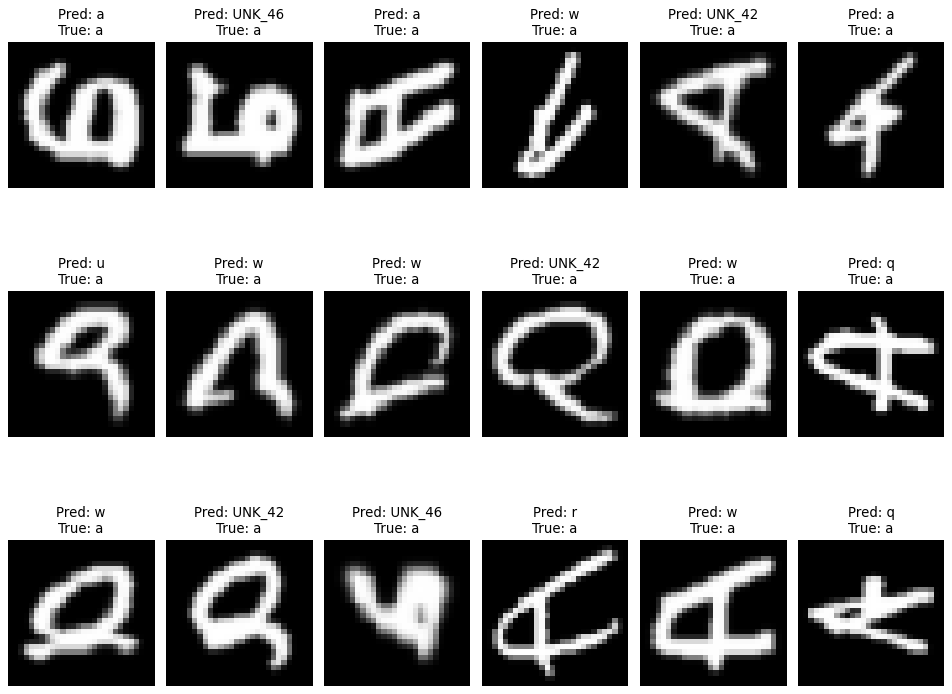

In [8]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, recall_score,
    log_loss, confusion_matrix
)

# Load and preprocess test data
def load_test_data(testing_letter):
    """Load and preprocess test data"""
    test_y = np.array(testing_letter.iloc[:, 0].values)
    test_x = np.array(testing_letter.iloc[:, 1:].values, dtype=np.float32)
    test_x = test_x / 255.0
    test_x = test_x.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
    encoder = OneHotEncoder(sparse_output=False, categories=[range(47)])
    test_y_onehot = encoder.fit_transform(test_y.reshape(-1, 1)).astype(np.float32)
    return test_x, test_y_onehot

# Create label mapping
def create_label_mapping(mapping_path):
    """Create dictionary mapping indices to letters"""
    mapp = pd.read_csv(mapping_path, sep=" ", header=None,
                      names=["index", "label"], index_col=0)
    label_dictionary = {index: chr(label) for index, label in mapp["label"].items()}
    
    # Ensure all indices from 0 to 46 are included
    for i in range(47):  # Assuming 47 classes
        if i not in label_dictionary:
            label_dictionary[i] = f"UNK_{i}"  # Add placeholder for unknown indices
    
    return label_dictionary

# Define the CNN model (Placeholder)
def cnn(params, x, is_training):
    """
    Placeholder for the CNN model.
    Replace this with your actual CNN implementation.
    """
    # Example: A simple CNN architecture
    x = x.reshape(x.shape[0], -1)  # Flatten the input
    x = jnp.dot(x, params['weights']) + params['bias']
    return x

# Generate predictions
@jax.jit
def predict(params, x):
    """Generate predictions using the CNN model"""
    logits = cnn(params, x, is_training=False)
    return jnp.argmax(logits, axis=-1)

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba, label_dictionary):
    """Calculate simplified classification metrics"""
    unique_classes = np.unique(y_true)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificities = []
    for i in unique_classes:
        tn = conf_matrix.sum() - (conf_matrix[i].sum() + conf_matrix[:,i].sum() - conf_matrix[i,i])
        fp = conf_matrix[:,i].sum() - conf_matrix[i,i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    mean_specificity = np.mean(specificities)
    encoder = OneHotEncoder(sparse_output=False, categories=[unique_classes])
    y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
    y_pred_proba_filtered = y_pred_proba[:, unique_classes]
    roc_auc_scores = []
    for i in range(len(unique_classes)):
        try:
            score = roc_auc_score(y_true_onehot[:, i], y_pred_proba_filtered[:, i])
            roc_auc_scores.append(score)
        except:
            roc_auc_scores.append(0.0)
    mean_roc_auc = np.mean(roc_auc_scores)
    logloss = log_loss(y_true_onehot, y_pred_proba_filtered)
    print("\nModel Performance Metrics:")
    print("=========================")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"ROC AUC (Mean): {mean_roc_auc:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Specificity (Mean): {mean_specificity:.4f}")

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': mean_roc_auc,
        'recall': recall,
        'log_loss': logloss,
        'specificity': mean_specificity
    }

# Visualize predictions
def visualize_predictions(test_x, y_pred_test, y_true_test, label_dictionary,
                         start_idx=200, num_samples=18):
    """Visualize model predictions with true and predicted labels"""
    plt.figure(figsize=(12, 10), dpi=80)
    for i in range(num_samples):
        plt.subplot(3, 6, i + 1)
        plt.imshow(test_x[start_idx + i].reshape(28, 28), cmap=plt.cm.gray)

        predicted_label = label_dictionary.get(int(y_pred_test[start_idx + i]), "UNK")
        true_label = label_dictionary.get(int(y_true_test[start_idx + i]), "UNK")

        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Load testing dataset
    testing_letter = pd.read_csv(r"C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-letters-test.csv", header=None)
    test_x, test_y_onehot = load_test_data(testing_letter)

    # Load label mapping
    mapping_path = r"C:\Users\admin\.cache\kagglehub\datasets\crawford\emnist\versions\3\emnist-letters-mapping.txt"
    label_dictionary = create_label_mapping(mapping_path)

    # Load trained parameters (Placeholder)
    # Replace this with your actual method of loading trained parameters
    params = {
        'weights': jnp.array(np.random.randn(28 * 28, 47)),  # Example weights
        'bias': jnp.zeros(47)  # Example bias
    }

    # Generate predictions
    y_pred_proba = jax.nn.softmax(cnn(params, test_x, is_training=False))
    y_pred_test = np.argmax(y_pred_proba, axis=-1)
    y_true_test = np.argmax(test_y_onehot, axis=-1)

    # Clip indices to the valid range [0, 46]
    y_pred_test = np.clip(y_pred_test, 0, 46)
    y_true_test = np.clip(y_true_test, 0, 46)

    # Calculate metrics
    metrics = calculate_metrics(
        np.array(y_true_test),
        np.array(y_pred_test),
        np.array(y_pred_proba),
        label_dictionary
    )

    # Visualize predictions
    visualize_predictions(test_x, y_pred_test, y_true_test, label_dictionary)

if __name__ == "__main__":
    main()